Kaushika Uppu

Winter 2024

University of California, San Diego

## Introduction {-}

Large language models have become significantly prevalent in recent years, resulting in an explosion of users and usage. With its exponential rise in popularity, LLMs are now being used for everything from coding to homework to essay writing, and many other things in between. Although previous work in this class has shown the extent to which large language models, specifically GPT-2, are sensitive to certain grammatical errors, I was curious about how large language models react to friendliness versus unfriendliness.

The idea of friendly behavior, or behavior that aids someone in some kind of positive way, is known as prosocial behavior. Both empathy and prosocial behavior are known to develop in young children during early childhood [<sup>[1]</sup>](#fn1), and they are a critical aspect of social interaction and understanding. On the other hand, large language models have grown and expanded substantially in the past few years, and have even been used to model human behavior in certain situations. One study [<sup>[2]</sup>](#fn2) found that LLMs can even simulate one aspect of human social understanding: trust. Therefore, it is possible that large language models are able to replicate facets of social behaviors that are a prominent feature of human development.

With social behavior being such a central component of human society and the idea that large language models are becoming more and more advanced to the point of accurately simulating human behavior, I was interested in seeing whether LLMs would be sensitive to one aspect of this kind of behavior. In this project, I aim to test how much large language models are responsive to the difference between situations in which one acts amicably or not.

## Research Question {-}

Are large language models (LLMs) sensitive to the difference between friendly and unfriendly behavior?

## Methods {-}

### Imports {-}

To set up for this project, I first installed and imported the necessary libraries, and loading the GPT-2 tokenizer as well as the pre-trained GPT-2 model that will be used later.

In [2]:
#%pip install transformers
#%pip install pytorch

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import torch
import transformers

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")

In [5]:
gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")
gpt2.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Stimuli {-}

In order to test the sensitivity of large language models to friendly versus unfriendly behavior, I created stimuli with ten minimal pairs, for a total of twenty sentences. Minimal pairs that were developed were completely identitical except for the last word of the sentence that either reflected amicable behavior or antagonistic behavior, which allowed for the control of everything but the final word.

Each stimulus in the list is a tuple that has four parts: a sentence fragment, the final word, a label identifying whether the final word is `Friendly` (modeling amicable behavior in the situation) or `Unfriendly` (modeling antagonistic behavior in the situation), and the sex of the subject in the sentence.

The sex of the subject in the sentence was included in the stimuli because I was also curious whether sex would play a role in the large language model's sensitivity to friendly and unfriendly behavior due to any unseen biases. While developing these stimuli, I created exactly five pairs of sentences with male pronouns and five with female, labeled `m` and `f`, respectively.

In [6]:
test_stimuli = [
    ("He saw his friend trip over a rock and", " helped", "Friendly", "m"),
    ("He saw his friend trip over a rock and", " laughed", "Unfriendly", "m"),
    ("When the girl went to the teacher to ask a question, the teacher", " answered", "Friendly", "f"),
    ("When the girl went to the teacher to ask a question, the teacher", " yelled", "Unfriendly", "f"),
    ("She saw a lonely dog on the side of the road while driving, so she", " stopped", "Friendly", "f"),
    ("She saw a lonely dog on the side of the road while driving, so she", " snickered", "Unfriendly", "f"),
    ("He realized his colleague was struggling on the project, and offered to", " help", "Friendly", "m"),
    ("He realized his colleague was struggling on the project, and offered to", " gloat", "Unfriendly", "m"),
    ("During the soccer game, she noticed her teammate was injured and", " rushed", "Friendly", "f"),
    ("During the soccer game, she noticed her teammate was injured and", " complained", "Unfriendly", "f"),
    ("When his friend was feeling sad, he took the time to", " listen", "Friendly", "m"),
    ("When his friend was feeling sad, he took the time to", " insult", "Unfriendly", "m"),
    ("Upon hearing about his friend's win yesterday, he was quick to", " congratulate", "Friendly", "m"),
    ("Upon hearing about his friend's win yesterday, he was quick to", " envy", "Unfriendly", "m"),
    ("When her group member made a small mistake on the paper, she chose to", " forgive", "Friendly", "f"),
    ("When her group member made a small mistake on the paper, she chose to", " reprimand", "Unfriendly", "f"),
    ("Her classmate was sad about his grade, and she decided to", " console", "Friendly", "f"),
    ("Her classmate was sad about his grade, and she decided to", " mock", "Unfriendly", "f"),
    ("He noticed a kid in class sitting alone, and chose to", " invite", "Friendly", "m"),
    ("He noticed a kid in class sitting alone, and chose to", " exclude", "Unfriendly", "m")
    ]

### Analysis {-}

In order to analyze the sensitivity of the large language model to this behavior, I used the metric of surprisal. Surprisal measures how "surprised" the model is by a particular word, which therefore reveals how probable a certain word is. If surprisal is higher, that means that there is a lower probability of that certain word appearing in a given context. Surprisal is defined as the negative log of probability, as seen in the function below.

In [7]:
def surprisal(prob):
  return -np.log2(prob)

With the stimuli created, I then transformed them into a data frame, separated by `Sentence`, `Word`, `Condition` (which is `Friendly` or `Unfriendly`), and `Sex`.

In [8]:
df_stimuli = pd.DataFrame(test_stimuli, columns = ['Sentence', 'Word', 'Condition', 'Sex'])

The next function is one that was used in class during the second lab, which calculates the probability of the "unseen" word, which is the final word in the sentence, given the probability of the "seen" words, which is the rest of the sentence in each stimulus. Once this function is run on each stimulus, a probability is returned, which will then be used to calculate surprisal.

In [9]:
def next_seq_prob(model, tokenizer, seen, unseen):
    """Get p(unseen | seen)

    Parameters
    ----------
    model : transformers.PreTrainedModel
        Model to use for predicting tokens
    tokenizer : transformers.PreTrainedTokenizer
        Tokenizer for Model
    seen : str
        Input sequence
    unseen: str
        The sequence for which to calculate a probability
    """
    # Get ids for tokens
    input_ids = tokenizer.encode(seen, return_tensors="pt")
    unseen_ids = tokenizer.encode(unseen)

    # Loop through unseen tokens & store log probs
    log_probs = []
    for unseen_id in unseen_ids:

        # Run model on input
        with torch.no_grad():
            logits = model(input_ids).logits

        # Get next token prediction logits
        next_token_logits = logits[0, -1]
        next_token_probs = torch.softmax(next_token_logits, 0) # Normalize

        # Get probability for relevant token in unseen string & store
        prob = next_token_probs[unseen_id]
        log_probs.append(torch.log(prob))

        # Add input tokens incrementally to input
        input_ids = torch.cat((input_ids, torch.tensor([[unseen_id]])), 1)

    # Add log probs together to get total log probability of sequence
    total_log_prob = sum(log_probs)
    # Exponentiate to return to probabilities
    total_prob = torch.exp(total_log_prob)
    return total_prob.item()

For each stimulus in `test_stimuli`, the probability is calculated using the function above. Then, the word, sentence, condition, sex condition, probability, and surprisal for each stimulus is appended to a list called `results` containing this information for all of the stimuli. This was then converted into a dataframe to be easily viewed and visualized.

In [10]:
results = []
for index, row in tqdm(df_stimuli.iterrows(), total=df_stimuli.shape[0]):

  p = next_seq_prob(gpt2, tokenizer, row['Sentence'], row['Word'])

  results.append({
      'Word': row['Word'],
      'Sentence': row['Sentence'],
      'Condition': row['Condition'],
      'Sex': row['Sex'],
      'Probability': p,
      'Surprisal': surprisal(p)
  })

df_results = pd.DataFrame(results)
df_results

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 16.03it/s]


,Word,Sentence,Condition,Sex,Probability,Surprisal
0,helped,He saw his friend trip over a rock and,Friendly,m,0.000156,12.645842
1,laughed,He saw his friend trip over a rock and,Unfriendly,m,0.000061,13.999645
2,answered,When the girl went to the teacher to ask a que...,Friendly,f,0.002249,8.796256
3,yelled,When the girl went to the teacher to ask a que...,Unfriendly,f,0.003914,7.997134
4,stopped,She saw a lonely dog on the side of the road w...,Friendly,f,0.020985,5.574504
5,snickered,She saw a lonely dog on the side of the road w...,Unfriendly,f,0.000006,17.233319
6,help,He realized his colleague was struggling on th...,Friendly,m,0.219425,2.188202
7,gloat,He realized his colleague was struggling on th...,Unfriendly,m,0.000003,18.267286
8,rushed,"During the soccer game, she noticed her teamma...",Friendly,f,0.032421,4.946915
9,complained,"During the soccer game, she noticed her teamma...",Unfriendly,f,0.000637,10.616399


## Results {-}

### Friendly Vs. Unfriendly Behavior {-}

The probability and surprisal that were calculated for the stimuli are shown in the plots below.

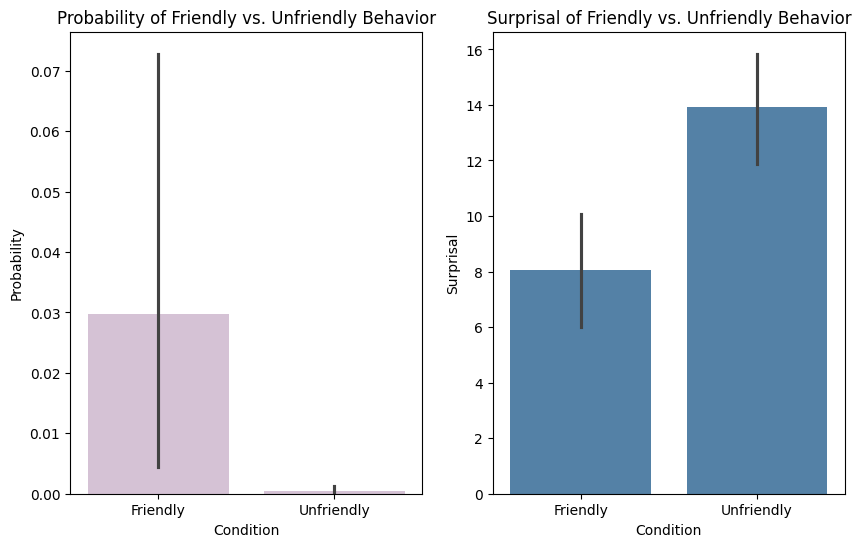

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
sns.barplot(df_results, x='Condition', y='Probability', ax=axs[0], color='thistle');
axs[0].set_title('Probability of Friendly vs. Unfriendly Behavior');
sns.barplot(df_results, x='Condition', y='Surprisal', ax=axs[1], color='steelblue');
axs[1].set_title('Surprisal of Friendly vs. Unfriendly Behavior');

As seen in the plots above, there is a prominent difference in probability, and hence surprisal, between friendly and unfriendly conditions. The surprisal for antagonistic behaviors in the given situations are significantly higher than for amicable behaviors, thus demonstrating that this large language model is at least somewhat sensitive to friendly versus unfriendly behavior, with friendly behavior being more likely.

### The Effect of Sex {-}

As mentioned above, I was intrigued by the idea that sex might have an effect on surprisal as a result of inherent biases of the model, and I wanted to test whether surprisal differed by condition based on the sex of the subject in the sentence.

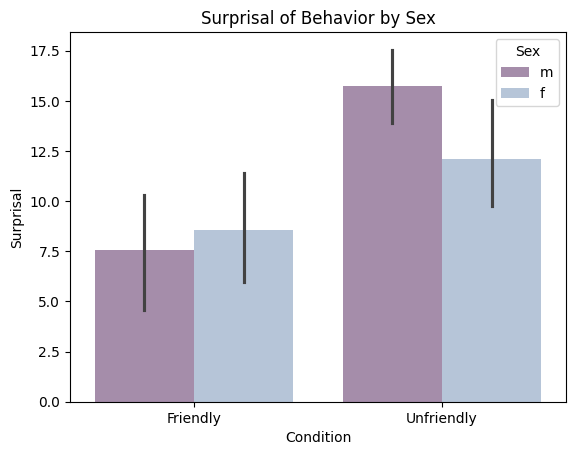

In [12]:
palette = ["#A888AF", 'lightsteelblue']
sns.set_palette(palette)
sns.barplot(df_results, x='Condition', y='Surprisal', hue='Sex', palette=palette).set_title('Surprisal of Behavior by Sex');

These results were interesting, as surprisal was slightly higher for the female condition for friendly behaviors, while it was slightly higher for the male condition for unfriendly behaviors. This difference was not significant at all, as seen in the plot above. However, I still found this fascinating, because it could reveal that there are unknown biases in the LLM itself that biases friendly behavior towards males and unfriendly behavior towards females. Although in this project I cannot say for certain whether this bias does truly exist, it is something that is intriguing, and further work would involve analyzing this possible bias more extensively with additional, more robust stimuli. 

## Discussion {-}

Large language models have been shown to be sensitive to human social behaviors in prior research, with the ability to model facets such as human trust behaviors. However, I wanted to test whether GPT-2 is sensitive to prosocial behaviors, specifically in the case of friendly versus unfriendly behaviors in given situations. 

After calculating the surprisal for the stimuli I developed that included ten minimal pairs of sentences such that each pair had a `Friendly` final word or an `Unfriendly` final word, I found that GPT-2 was in fact sensitive to the difference between amicable behavior and antagonistic behavior. The surprisals for unfriendly behavior were significantly higher than the ones for friendly behavior, indicating that this large language model is more unlikely to lean towards antagonistic behavior when given a social situation.

Furthermore, I also analyzed whether sex had an effect on this distinction. Unsurprisingly, the difference between surprisal for the male condition and the female condition was not significant with the stimuli that I developed, as there were only five minimal pairs for each condition in this dataset. However, for the male condition, surprisal was marginally higher in the `Unfriendly` behavior condition, while it was marginally lower in the `Friendly` behavior condition. Since this disparity was not significant, it is hard to tell whether this indicates an inherent bias in the large language model. 

One important implication that these results have for the capacities of large language models is that they demonstrate that LLMs have the ability to model human behavior in some capacity. Although they might not be able to perfectly replicate social interactions and understanding in the same way that adults or even younger children do, they do seem to have some kind of sensitivity to the difference between amicable and antagonistic behavior. In the future, this could mean that LLMs might be used more extensively to model what a human might do in certain situations, which could be helpful in various fields, but especially human social science research. Being able to accurately mirror human social interactions without using real human participants in a research study could lead to decreased costs and increased efficiency in the long run.

With respect to the implications for human cognition, these results imply that large language models could be integrated into society in a way that human cognition becomes intertwined with LLMs. As seen already with technology in the past couple of decades, as the abilities of large language models continue to become more and more advanced, human cognition might become more and more dependent on the use of LLMs in daily lives. This integration could have lasting impacts on the future of human cognition, as it would mean the necessary change in the way humans interact with technology and large language models, and possibly even each other. Although these results are not very robust in implying that LLMs could eventually fully and accurately mimic human social interaction and understanding, they do reveal some level of modeling human cognition.

### Limitations {-}

There are a few important limitations of this project. In terms of the stimuli used, one possible issue is that the dataset was simply too small. There were only ten minimal pairs in the dataset (twenty total sentences), which is a relatively limited amount of data. Analyses on a small amount of data such as this might lead to results that don't capture the true nature of the large language model, and therefore lead to incorrect conclusions, specifically in terms of both modeling prosocial behavior as well as the effect of sex in this project. Furthermore, another probable issue with the test stimuli is that they were not fully controlled for difficulty. Some of the final words might be considered more complex than others, and therefore could be a confound in this analysis.

### Next Steps {-}

Taking into consideration the limitations of this project, next steps would include developing a larger dataset of stimuli containing minimal pairs so that any significant differences between conditions might be more robustly shown. Furthermore, when creating stimuli, complexity of both sentences and final words should be taken in to account such that they don't act as confounds in the project. 

In addition, in terms of the possible bias of sex, the stimuli used for this project did not reflect any significant variation between the male and female condition. However, future work should evaluate this further with a larger set of stimuli to see if this inherent bias is in fact present in GPT-2. The results of this project show a slight disparity, and I would be curious to know if there truly is a significant disparity for surprisal depending on whether the subject of the sentence is male or female.

## References {-}

<span id="fn1"> [1]</span> Spinrad, T. L., & Gal, D. E. (2018, April 1). *Fostering prosocial behavior and empathy in young children*. Current Opinion in Psychology. https://doi.org/10.1016/j.copsyc.2017.08.004

<span id="fn2"> [2]</span> Xie, C., Chen, C., Jia, F., Ye, Z., Shu, K., Bibi, A., Hu, Z., Torr, P., Ghanem, B., & Li, G. (2024, February 7). *Can Large Language Model Agents Simulate Human Trust Behaviors?* arXiv.org. https://arxiv.org/abs/2402.04559 